# Initial Implementation of Classification Models
Since I will need to run and re-run these, once I have settled on methodology then I will switch to .py files

In [41]:
import os
import pandas as pd
import numpy as np
import re

# ML
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
input_dir = "../data/heorData/"
output_dir = "../data/heorData/results/"

## Import and Process

In [43]:
# generate our df dictionary
def importDFs(input_dir, identifier = "_df"):
    # will update identifier = "some string" once I have multiple sets of dataframes
    # "_df" just means all for now
    split_dfs = {}
    files = os.listdir(input_dir)
    files = [f for f in files if re.search(identifier, f)]
    
    for f in files:
        c_search = re.search("\d", f)
        cluster = c_search.group(0) if c_search else "Total"
        split_dfs[cluster] = pd.read_csv(input_dir + f)
        
    return split_dfs

In [44]:
def genValidationSets(cluster_dfs, random_state = 42, split_perc = .2):
    # define our validation sets 
    keys = list(cluster_dfs.keys())
    cluster_keys = [k for k in keys if re.search("\d", k)]

    train_subjects, test_subjects = [], []

    # generate and store our train and test dataframes in our dictionary
    for ck in cluster_keys:
        df = cluster_dfs[ck]

        X_train, X_test, y_train, y_test = train_test_split(
            df.drop(columns = ['mortality30']), 
            df.mortality30, 
            test_size=split_perc, random_state=random_state)

        # add train and test subject IDs
        train_subjects += list(X_train.subject_id)
        test_subjects += list(X_test.subject_id)

        # drop subject_id
        X_train = X_train.drop(columns = "subject_id")
        X_test = X_test.drop(columns = "subject_id")

        # add to our dictionary
        cluster_dfs[ck] = {"X_train":X_train, "X_test":X_test,
                           "y_train":y_train, "y_test":y_test}

    # now we handle our total dataframe
    df = cluster_dfs['Total']
    train = df[df['subject_id'].isin(train_subjects)]
    test = df[df['subject_id'].isin(test_subjects)]

    X_train = train.drop(columns = ['subject_id', 'mortality30'])
    y_train = train.mortality30
    X_test = test.drop(columns = ['subject_id', 'mortality30'])
    y_test = test.mortality30

    # add to our dictionary
    cluster_dfs["Total"] = {"X_train":X_train, "X_test":X_test,
                            "y_train":y_train, "y_test":y_test}
    
    return split_dfs


## ML Pipeline

Steps:
  * create a LightGBM classifier
  * identify the top n most important features (plot = true?)
  * subset the dataframe to the top n most important features
  * recompute the LightGBM classifier
  * compute evaluate metrics for each tree and dataframe
  * generate weighted average 
  
How do I want to handle the validation set. I need to make them the same. Maybe I take 15% from each cluster dataframes, combine the subject_ids then extract these as the validation set


In [30]:
cat_vars = ["activity", "activity_tolerance", "braden_activity", "braden_mobility", 
            "family_communication", "marital_status", "race", "gender", "braden_nutrition", 
            "diet_type", "heart_rhythm", "lll_lung_sounds", "lul_lung_sounds", "rll_lung_sounds", 
            "rul_lung_sounds", "respiratory_effort", "respiratory_pattern", "mental_status", 
            "pain_cause", "pain_location", "pain_present", "pain_type", "abdominal_assessment", 
            "bowel_sounds", "braden_moisture", "cough_reflex", "gag_reflex", "oral_cavity", 
            "skin_color", "skin_condition", "speech", "appetite"]

# convert to pandas categorical
def convertCat(df, cat_vars):
    cat_vars_tmp = [c for c in cat_vars if c in df.columns]
    for col in cat_vars_tmp:
        df[col] = df[col].astype('category')
    return df

In [31]:
# run the classifier
def fitClf(X_train, y_train, X_test, y_test, metric = "auc"):
    # define our parameters
    fit_params={"early_stopping_rounds":10, 
            "eval_metric" : metric, 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # default
            'categorical_feature': 'auto' # default
           }

    # generate clf 
    clf = lgb.LGBMClassifier(is_unbalance = True, # this works much better than is_balanced = True
                         max_depth = 8, 
                         importance_type = "gain",
                         early_stopping = 10,
                         drop_rate = .9,
                         min_split_gain = .1)

    clf.fit(X_train, y_train, **fit_params)
    return clf


In [32]:
# Identify the most important features 
def plotImportance(feature_imp, n = 50):
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:n])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

def featureImportance(clf, X_train, top_n, plot = False):
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])
    
    if plot == True:
        plotImportance(feature_imp)
        
    # extract the top n features
    feature_imp = feature_imp.sort_values(by = "Value", ascending = False)
    return feature_imp, list(feature_imp.Feature[:top_n])

#feature_imp, imp_cols = featureImportance(clf, X_train, 50, plot = True)
#imp_cols

In [33]:
def subset2ImpCols(X_train, X_test, imp_cols):
    X_train = X_train[imp_cols]
    X_test = X_test[imp_cols]
    return X_train, X_test


In [34]:
# compute our evaluation metrics 
# will want to include filename somehow - but this is dependent on my naming system so will wait
# add to dataframe:  cluster, train_num_pts, val_num_pts auc, precision, recall, f1
def evalModel(cluster, clf, X_test, y_test):
    # number of patients
    train_num_pts = X_train.shape[0]
    val_num_pts = X_test.shape[0]

    # evaluate
    preds = clf.predict(X_test)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    auc_score = roc_auc_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # define our 1 row dataframe
    score_df = pd.DataFrame()
    score_df['cluster'] = [cluster]
    score_df['train_num_pts'] = train_num_pts
    score_df['val_num_pts'] = val_num_pts
    score_df['precision'] = precision
    score_df['recall'] = recall
    score_df['f1'] = f1
    score_df['auc'] = auc_score

    return score_df


In [35]:
# compute our cluster total
def computeClusterTotal(evaluation):
    cluster_eval = evaluation[evaluation['cluster'] != "Total"]
    total_pts = cluster_eval.val_num_pts.sum()
    cluster_eval['pt_perc'] = cluster_eval['val_num_pts'] / total_pts

    # compute metrics
    precision = sum(cluster_eval['precision']*cluster_eval['pt_perc'])
    recall = sum(cluster_eval['recall']*cluster_eval['pt_perc'])
    f1 = sum(cluster_eval['f1']*cluster_eval['pt_perc'])
    auc_score = sum(cluster_eval['auc']*cluster_eval['pt_perc'])

    # define our 1 row dataframe
    score_df = pd.DataFrame()
    score_df['cluster'] = ["Total Cluster"]
    score_df['train_num_pts'] = cluster_eval.train_num_pts.sum()
    score_df['val_num_pts'] = total_pts
    score_df['precision'] = precision
    score_df['recall'] = recall
    score_df['f1'] = f1
    score_df['auc'] = auc_score

    # add to our evaluation dataframe
    return pd.concat([evaluation, score_df], axis = 0)

## Run the entire process

In [36]:
from numpy.random import seed, randint
seed(100)
states = randint(0,100,5)
states

array([ 8, 24, 67, 87, 79])

['0_patient_df.csv', '1_patient_df.csv', 'results', 'total_patient_df.csv']
0
(1109, 119) (278, 119) (1109,) (278,)
Training until validation scores don't improve for 10 rounds


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[55]	valid's auc: 0.900324	valid's binary_logloss: 0.354662


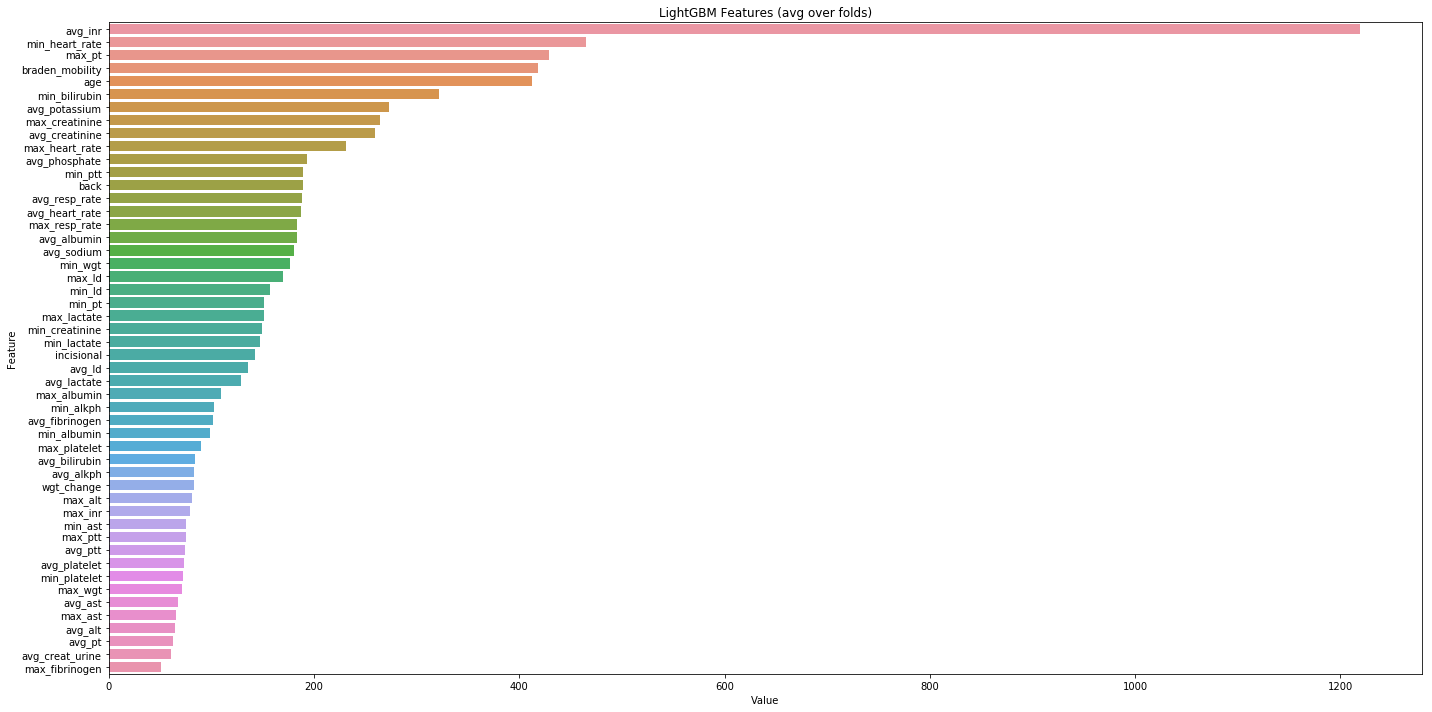

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid's auc: 0.895159	valid's binary_logloss: 0.365196
1
(1185, 152) (297, 152) (1185,) (297,)
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid's auc: 0.888253	valid's binary_logloss: 0.357529


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


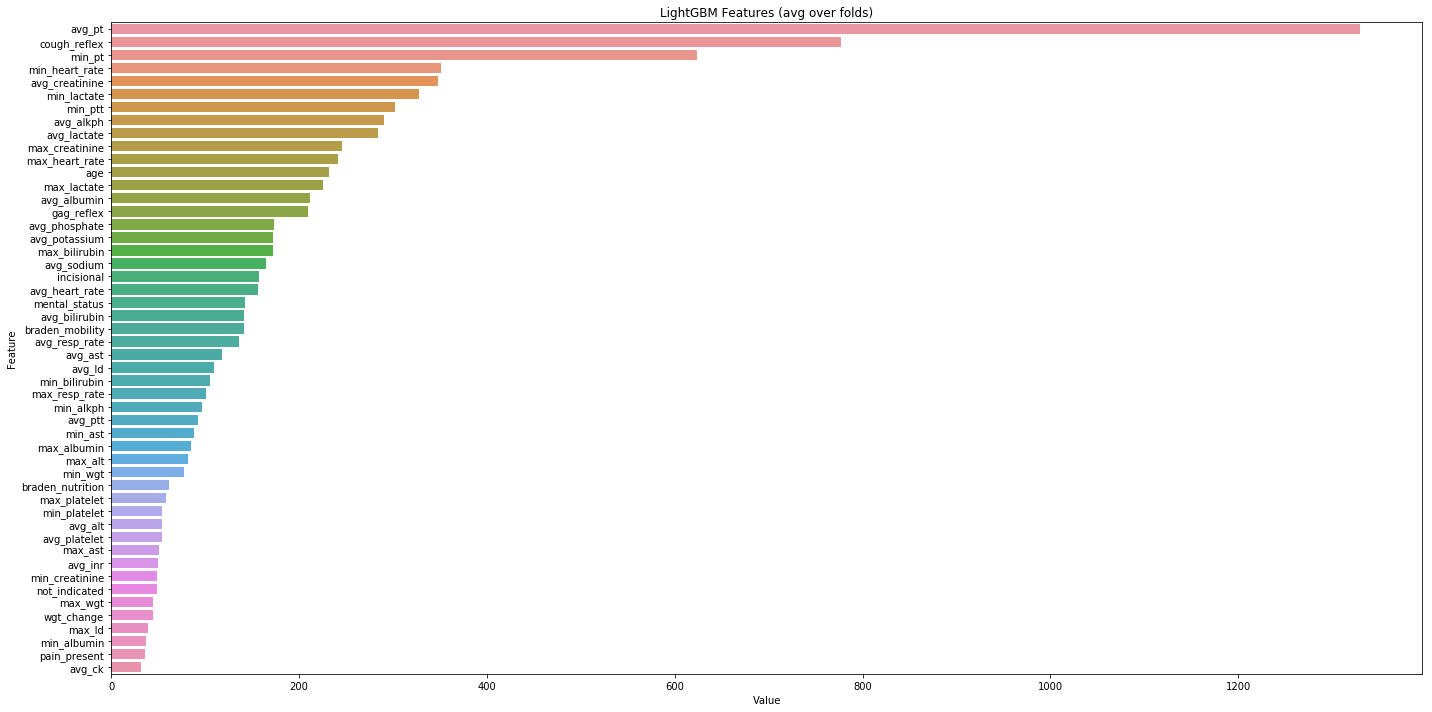

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid's auc: 0.894805	valid's binary_logloss: 0.347346
Total
(2294, 125) (575, 125) (2294,) (575,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid's auc: 0.90944	valid's binary_logloss: 0.328534


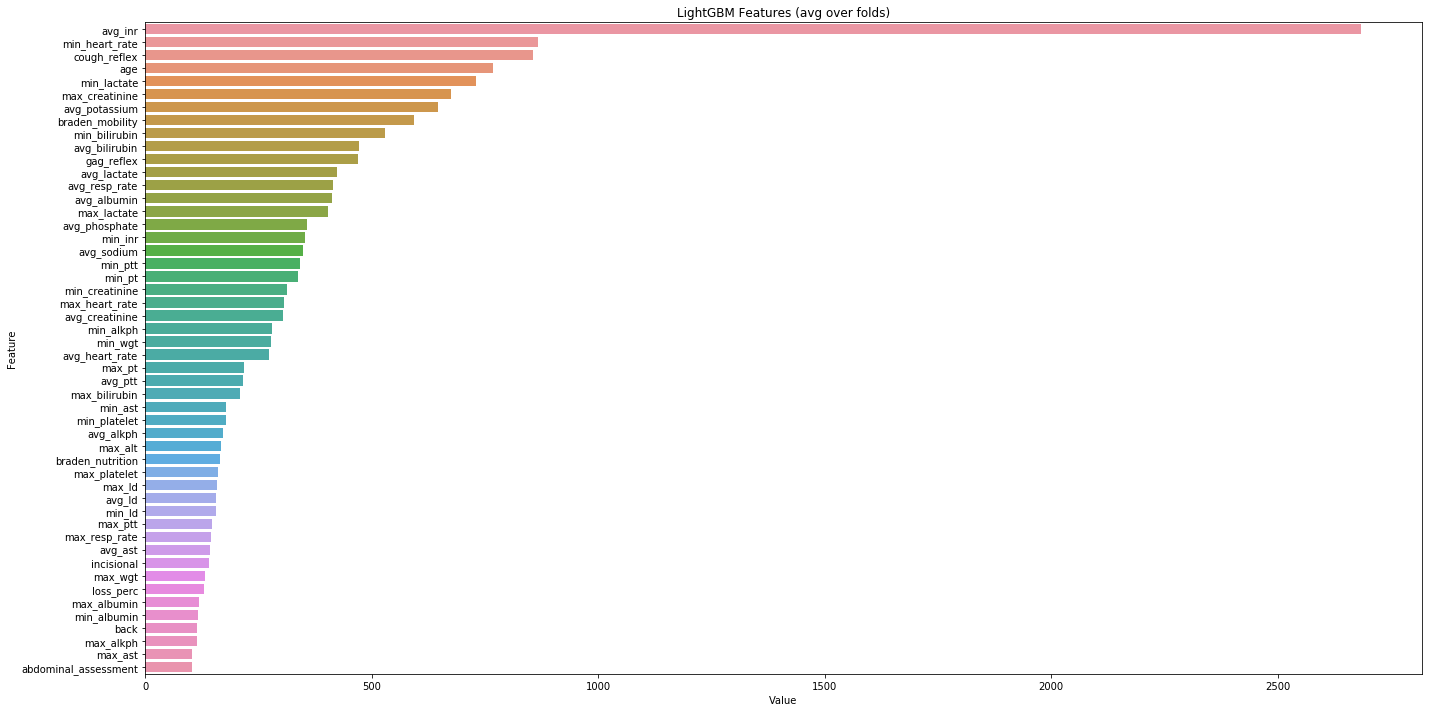

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ABell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid's auc: 0.898721	valid's binary_logloss: 0.35999
0
(1109, 119) (278, 119) (1109,) (278,)
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid's auc: 0.842349	valid's binary_logloss: 0.488949


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


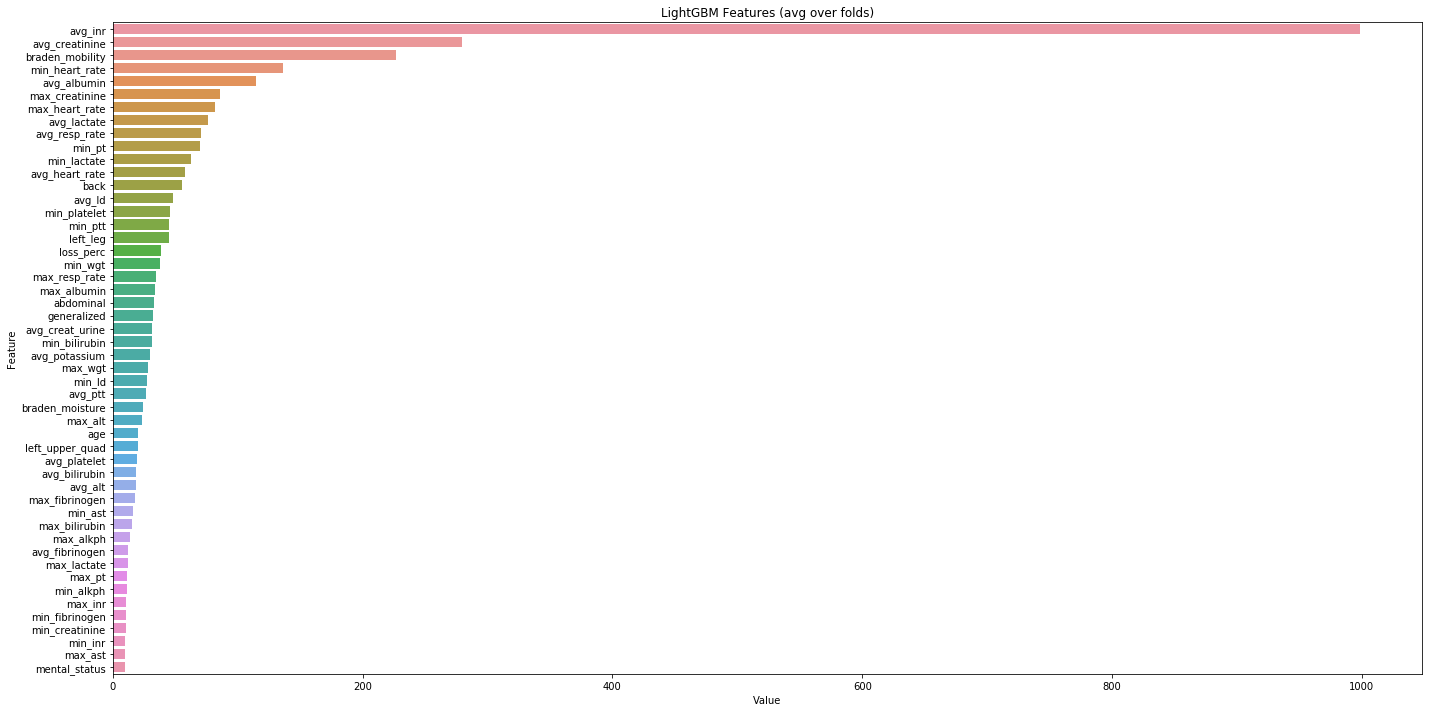

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid's auc: 0.859495	valid's binary_logloss: 0.411525
1
(1185, 152) (297, 152) (1185,) (297,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid's auc: 0.92858	valid's binary_logloss: 0.298593


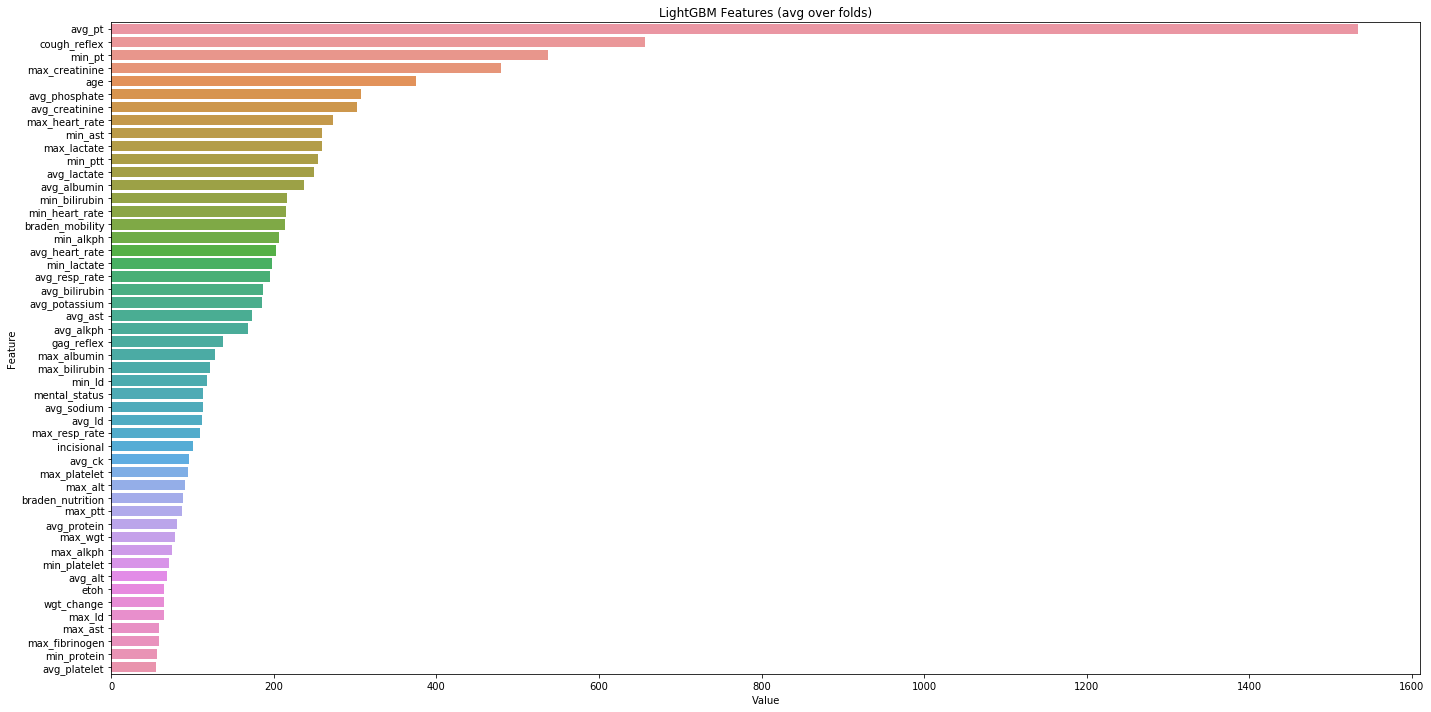

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.927116	valid's binary_logloss: 0.296246
Total
(2294, 125) (575, 125) (2294,) (575,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid's auc: 0.906796	valid's binary_logloss: 0.335909


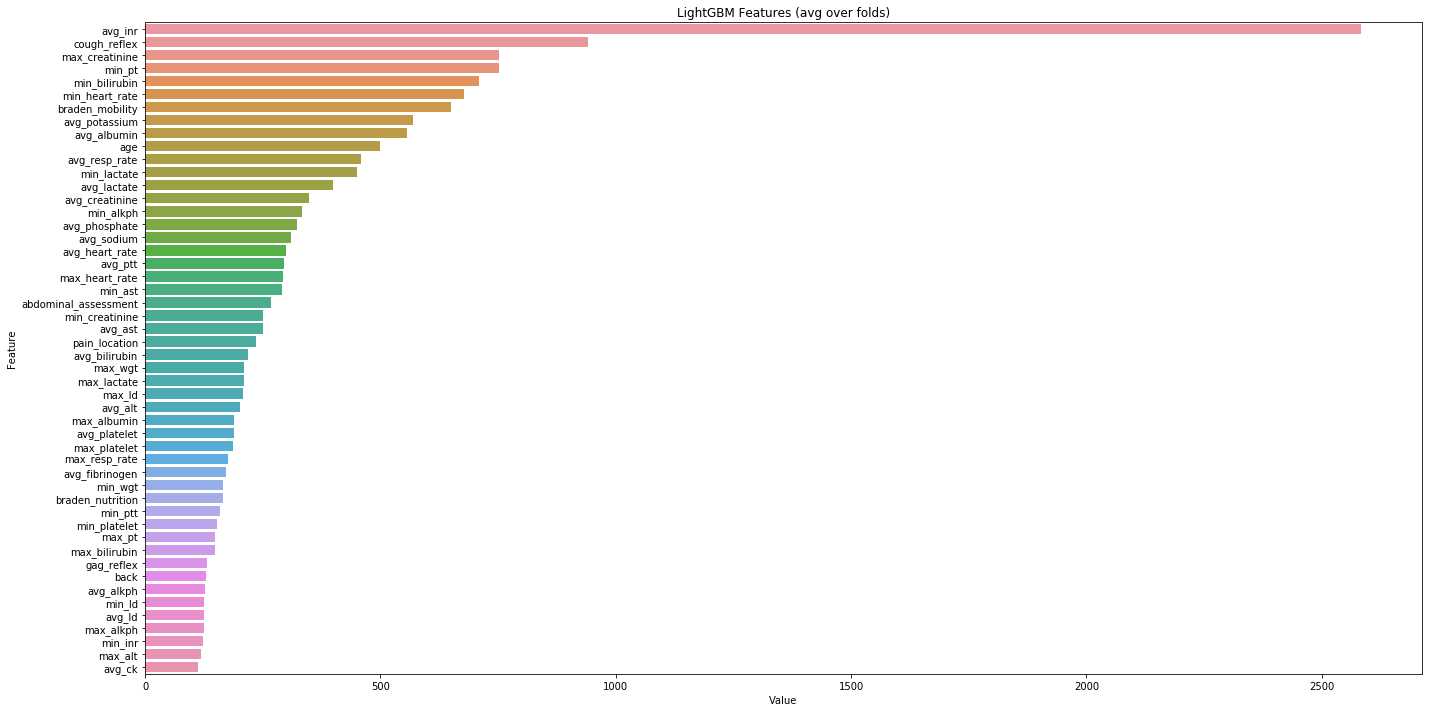

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ABell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid's auc: 0.900416	valid's binary_logloss: 0.361962
0
(1109, 119) (278, 119) (1109,) (278,)
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid's auc: 0.859015	valid's binary_logloss: 0.485282


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


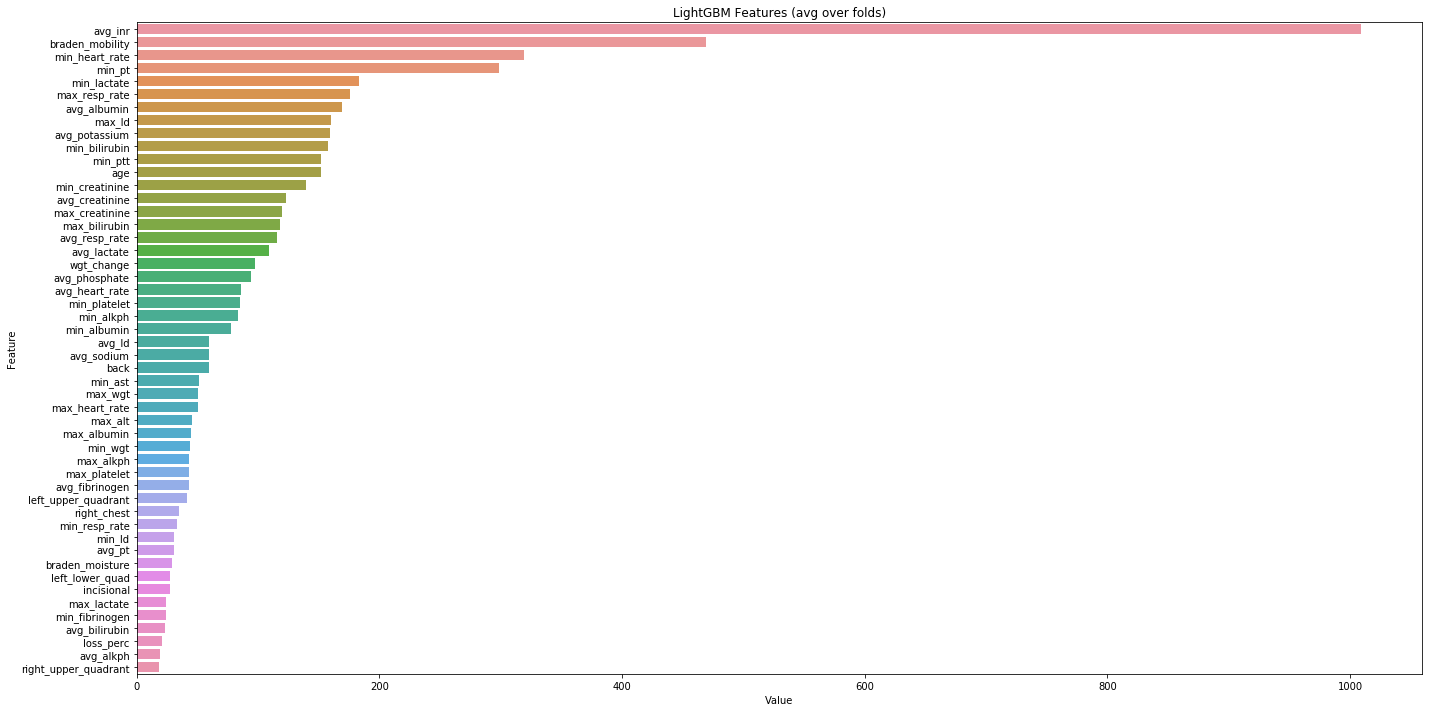

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid's auc: 0.850757	valid's binary_logloss: 0.514562
1
(1185, 152) (297, 152) (1185,) (297,)
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid's auc: 0.880176	valid's binary_logloss: 0.34143


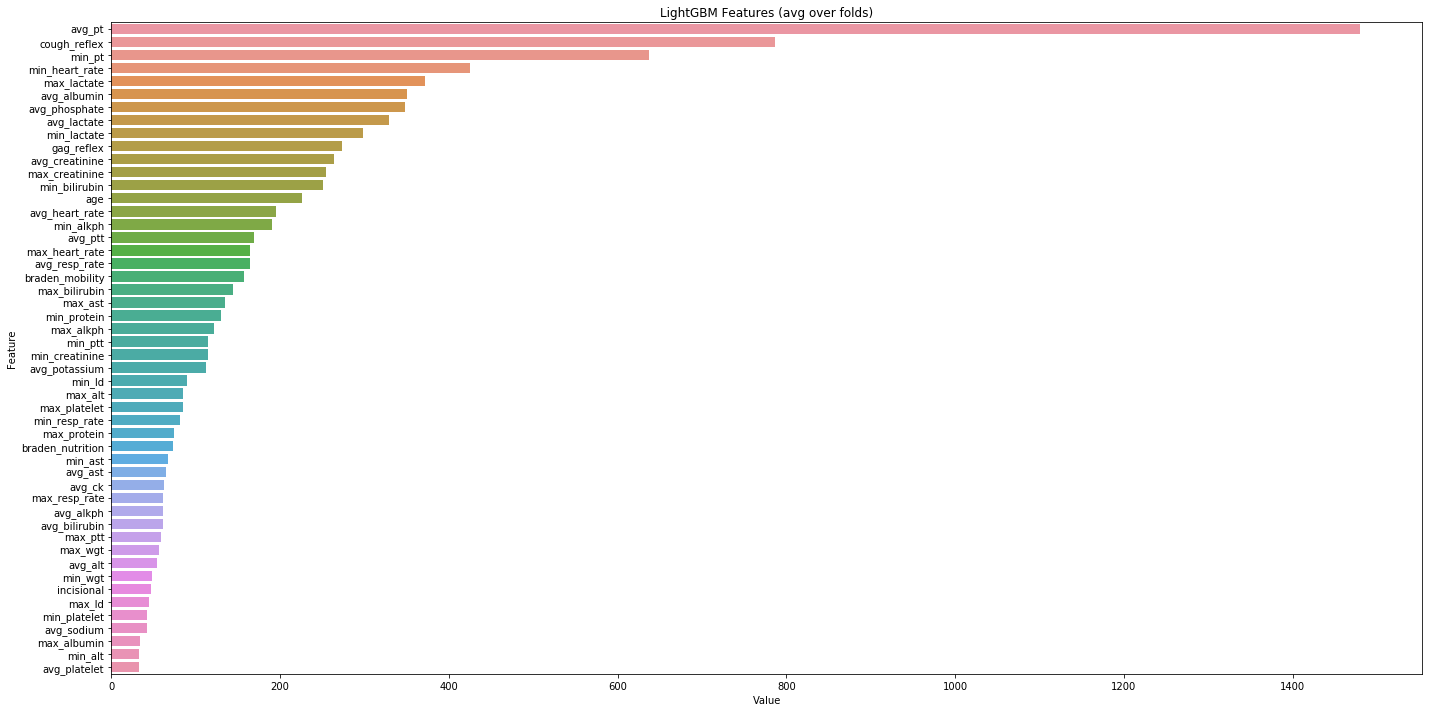

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid's auc: 0.887665	valid's binary_logloss: 0.340305
Total
(2294, 125) (575, 125) (2294,) (575,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid's auc: 0.888371	valid's binary_logloss: 0.382401


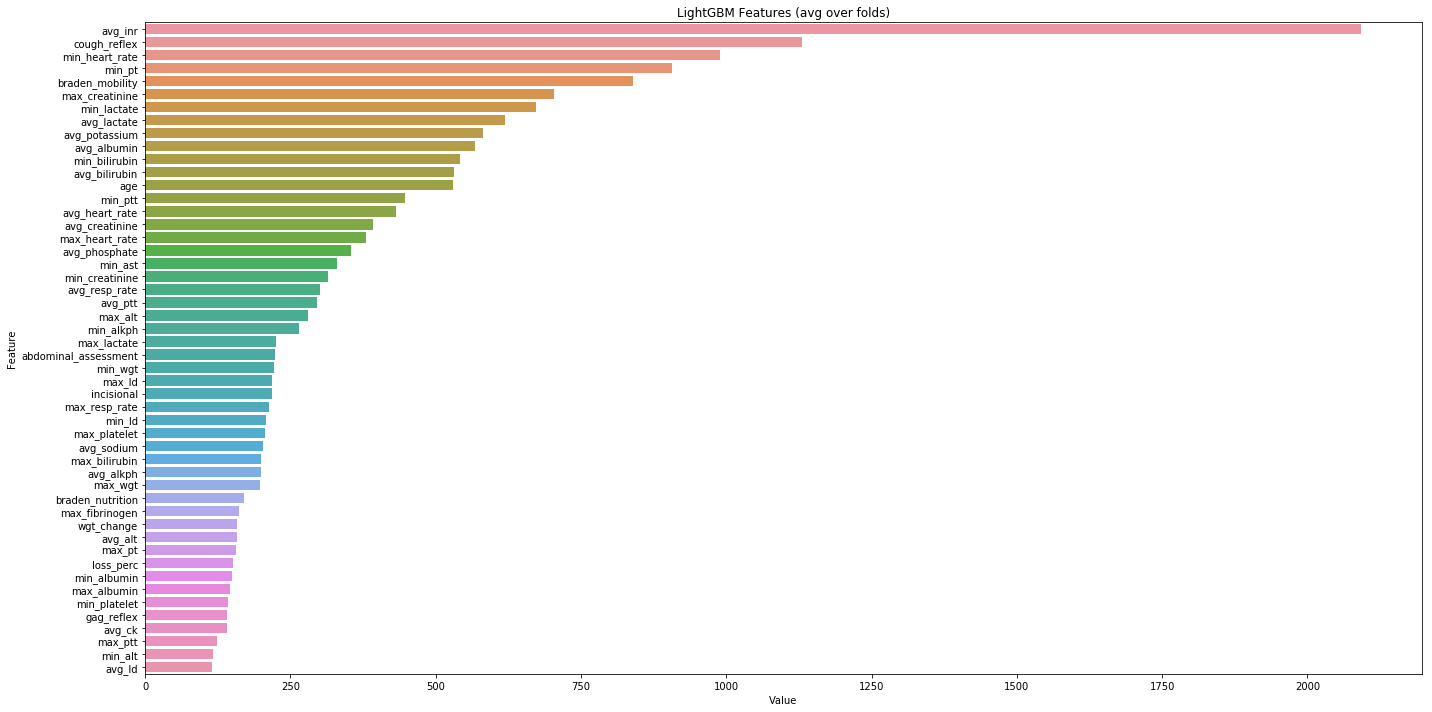

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ABell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.885214	valid's binary_logloss: 0.384239
0
(1109, 119) (278, 119) (1109,) (278,)
Training until validation scores don't improve for 10 rounds


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[25]	valid's auc: 0.852109	valid's binary_logloss: 0.437914


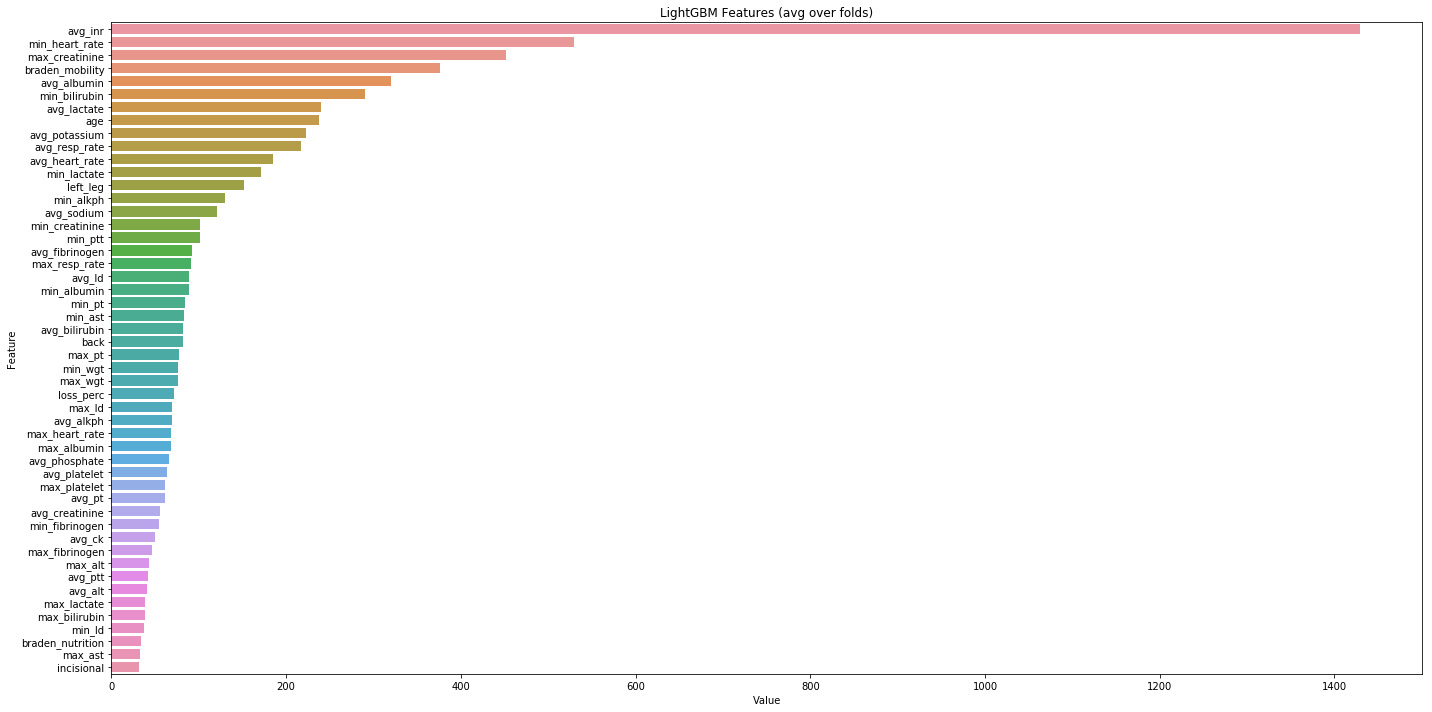

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid's auc: 0.837542	valid's binary_logloss: 0.449493
1
(1185, 152) (297, 152) (1185,) (297,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid's auc: 0.897108	valid's binary_logloss: 0.36167


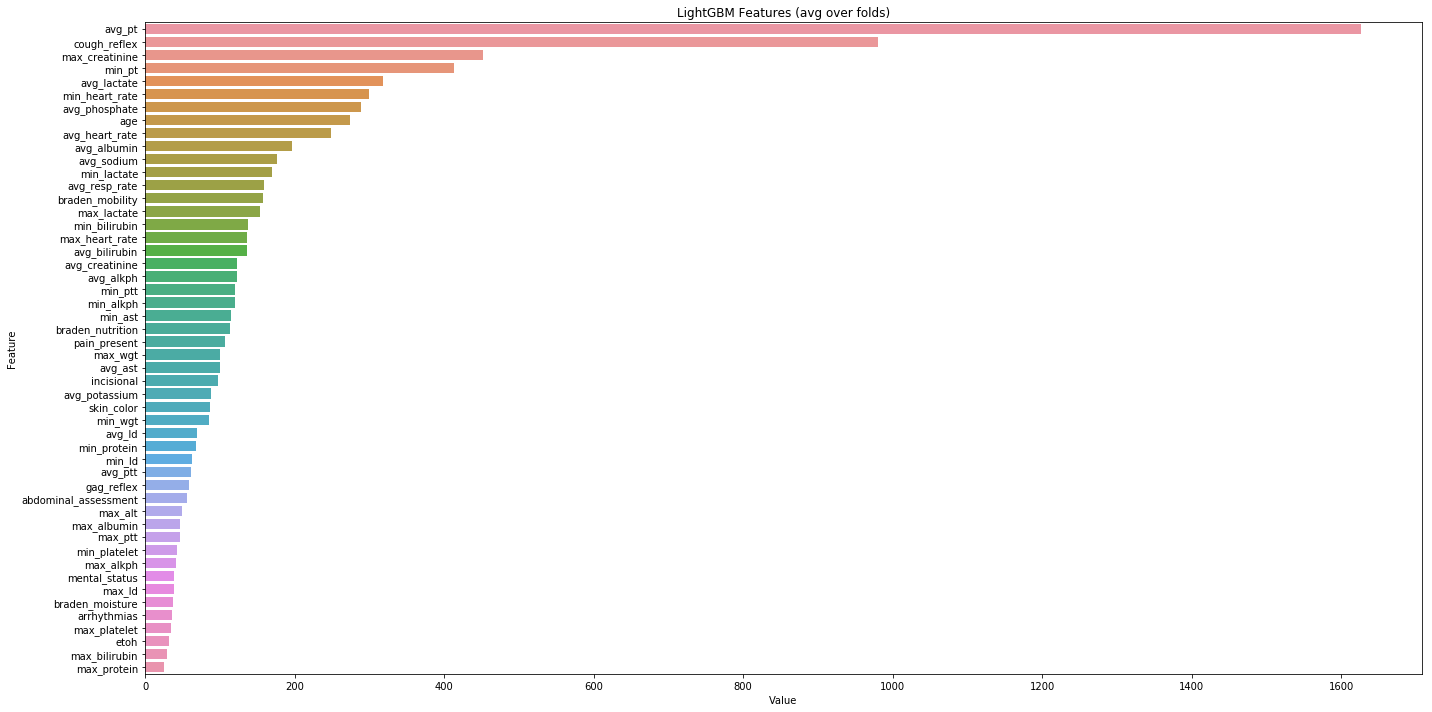

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid's auc: 0.903554	valid's binary_logloss: 0.342196
Total
(2294, 125) (575, 125) (2294,) (575,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid's auc: 0.88937	valid's binary_logloss: 0.378862


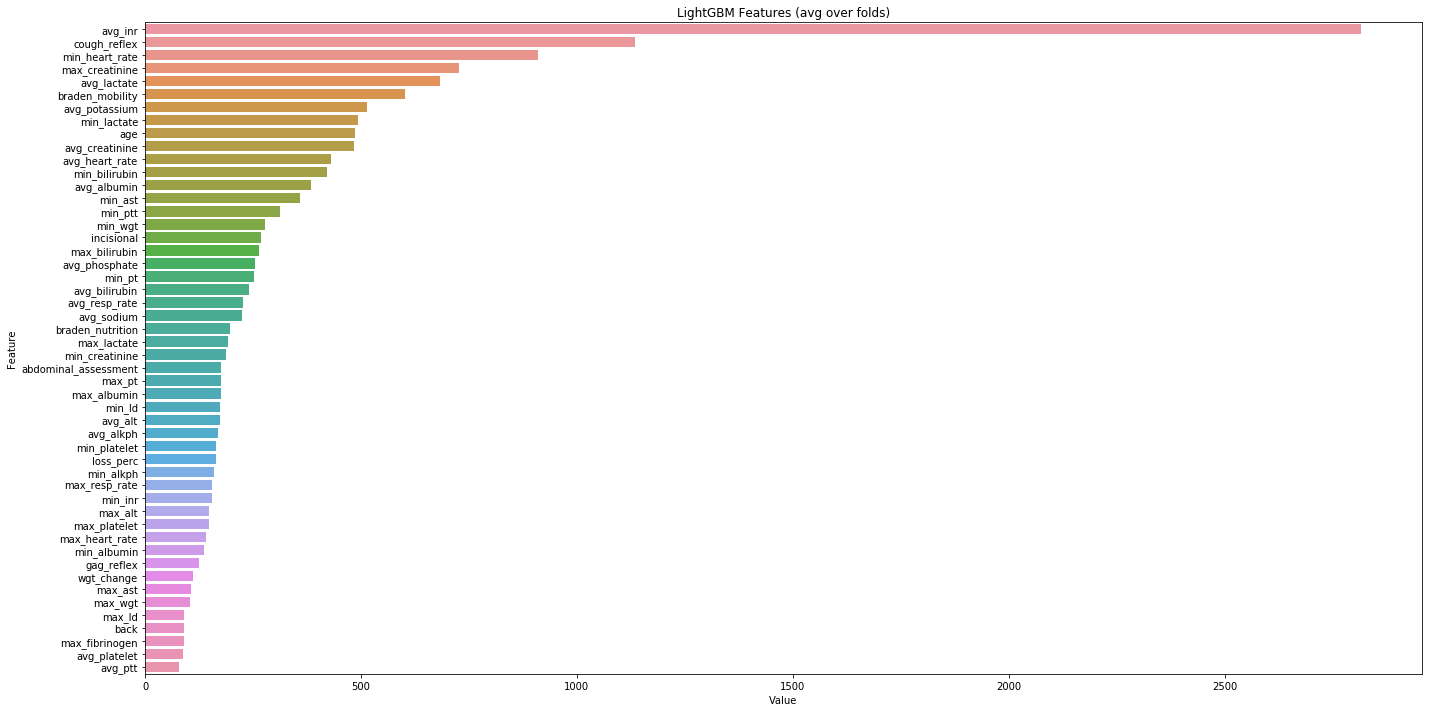

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ABell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid's auc: 0.887154	valid's binary_logloss: 0.379154
0
(1109, 119) (278, 119) (1109,) (278,)
Training until validation scores don't improve for 10 rounds


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[45]	valid's auc: 0.879739	valid's binary_logloss: 0.382022


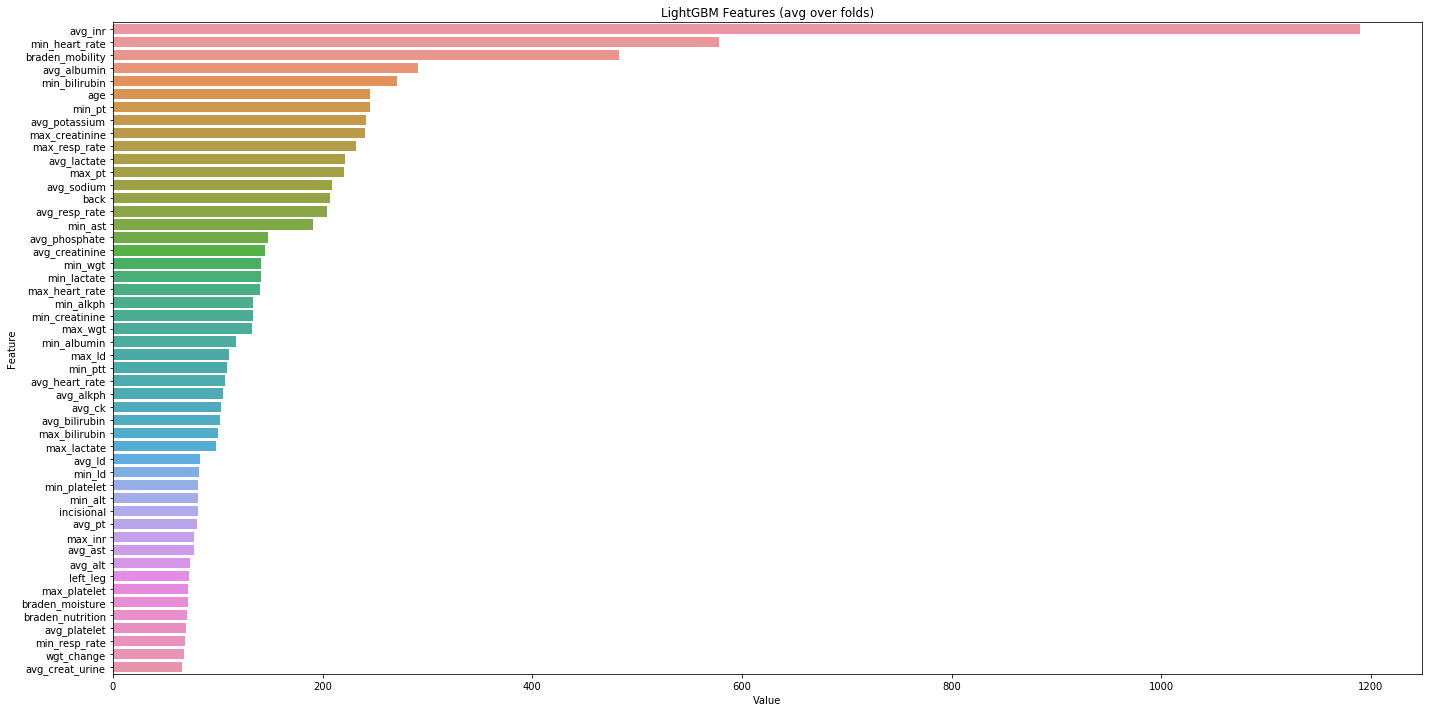

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid's auc: 0.882371	valid's binary_logloss: 0.381759
1
(1185, 152) (297, 152) (1185,) (297,)


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid's auc: 0.891189	valid's binary_logloss: 0.339798


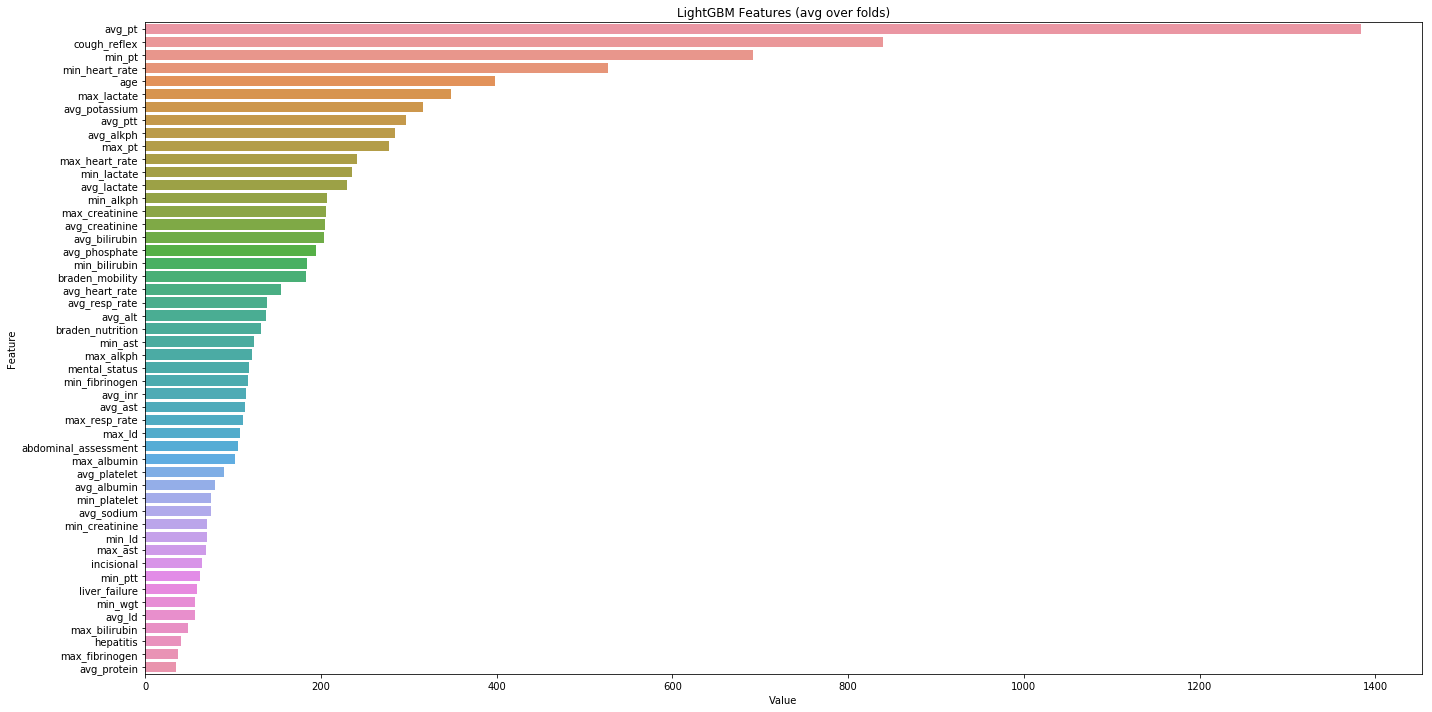

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid's auc: 0.891756	valid's binary_logloss: 0.341817
Total
(2294, 125) (575, 125) (2294,) (575,)
Training until validation scores don't improve for 10 rounds


C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[42]	valid's auc: 0.885621	valid's binary_logloss: 0.366708


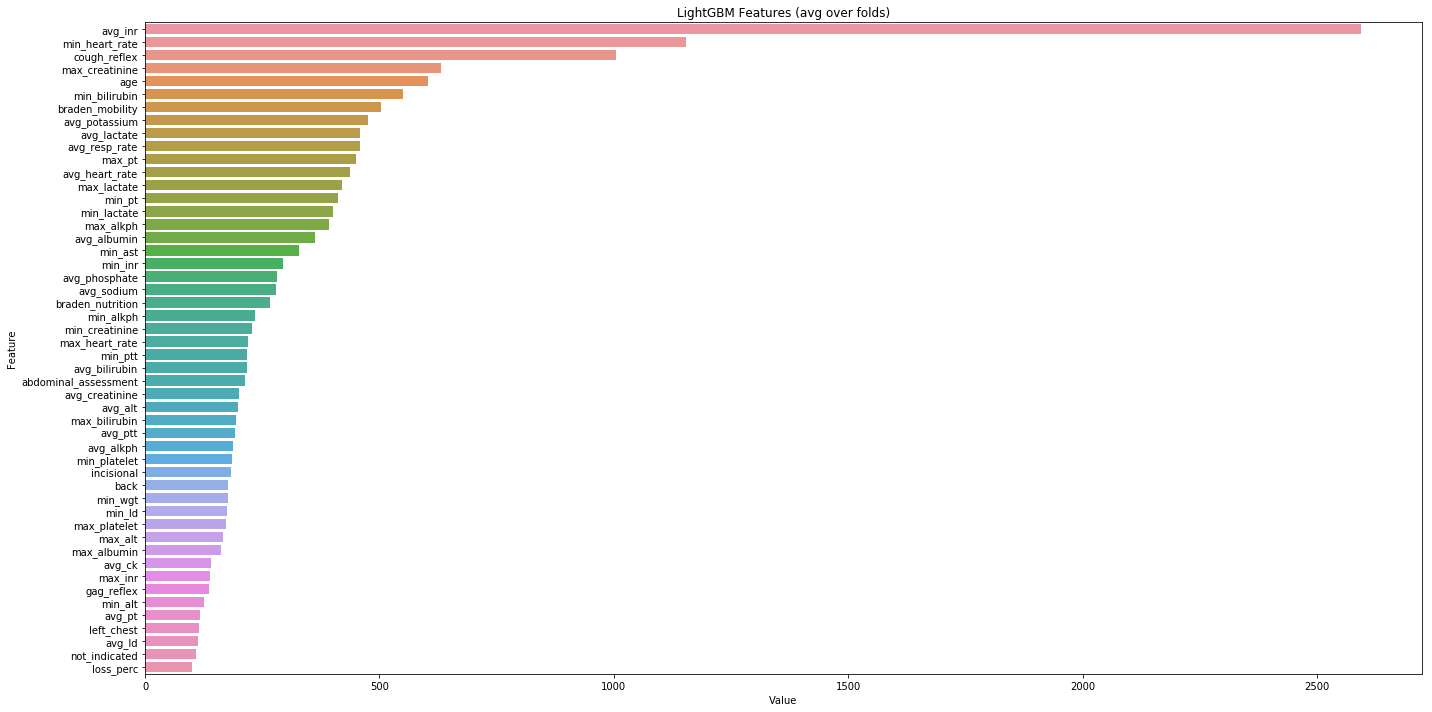

C:\Users\ABell\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\ABell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid's auc: 0.881279	valid's binary_logloss: 0.373617


,cluster,train_num_pts,val_num_pts,precision,recall,f1,auc
0,0,1109,278,0.707317,0.707317,0.707317,0.792434
0,1,1185,297,0.746667,0.727273,0.736842,0.820455
0,Total,2294,575,0.715116,0.773585,0.743202,0.827898
0,Total Cluster,2294,575,0.727642,0.717625,0.722567,0.806907
0,0,1109,278,0.608696,0.591549,0.600000,0.730557
0,1,1185,297,0.782051,0.782051,0.782051,0.852213
0,Total,2294,575,0.672619,0.758389,0.712934,0.814641
0,Total Cluster,2294,575,0.698238,0.689948,0.694033,0.793395
0,0,1109,278,0.800000,0.495238,0.611765,0.710047
0,1,1185,297,0.761905,0.685714,0.721805,0.809817


In [37]:
# Run our analysis
files = os.listdir(input_dir)
print(files)

score_dfs = []
feature_imp_dfs = []

# maybe the best way for cross validation is to try a bunch of random states then average them>?
for rs in states:
    split_dfs = importDFs(input_dir)
    split_dfs_tmp = genValidationSets(split_dfs, random_state = rs)

    scores = []
    for cluster, df_group in split_dfs_tmp.items():
        print(cluster)
        # extract our train test splits
        X_train, X_test = df_group['X_train'], df_group['X_test']
        y_train, y_test = df_group['y_train'], df_group['y_test']

        # convert to category types
        X_train = convertCat(X_train, cat_vars)
        X_test = convertCat(X_test, cat_vars)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        # ML pipeline
        clf = fitClf(X_train, y_train, X_test, y_test)

        # identify important features and subset
        feature_imp, imp_cols = featureImportance(clf, X_train, 50, plot = True)
        X_train, X_test = subset2ImpCols(X_train, X_test, imp_cols)
        
        # store feature importances
        feature_imp['cluster'] = cluster
        feature_imp['seed'] = rs
        feature_imp_dfs.append(feature_imp)
        
        # retrain
        clf = fitClf(X_train, y_train, X_test, y_test)

        scores.append(evalModel(cluster, clf, X_test, y_test))


    score_dfs.append(computeClusterTotal(pd.concat(scores, axis = 0)))
    
evaluation = pd.concat(score_dfs, axis = 0)
evaluation

In [38]:
# now we average our entire validation set 
evaluation_final = evaluation.groupby(['cluster'], as_index = False).mean()
#del evaluation_final.index.name
evaluation_final

,cluster,train_num_pts,val_num_pts,precision,recall,f1,auc
0,0,1109,278,0.699518,0.621143,0.652943,0.754049
1,1,1185,297,0.750878,0.710653,0.729687,0.815711
2,Total,2294,575,0.701360,0.718610,0.708203,0.801149
3,Total Cluster,2294,575,0.726047,0.667377,0.692583,0.785899


In [39]:
# get our feature importances across all CVs
feature_imps = pd.concat(feature_imp_dfs, axis = 0)
feature_imps = feature_imps.groupby(["Feature", "cluster"], as_index = False).sum()\
                            .drop(columns = "seed")\
                            .sort_values(by = ['cluster', 'Value'], ascending = False)
feature_imps

,Feature,cluster,Value
51,avg_inr,Total,12771.501702
108,cough_reflex,Total,5068.121184
274,min_heart_rate,Total,4597.609873
209,max_creatinine,Total,3488.115573
94,braden_mobility,Total,3186.072094
...,...,...,...
366,right_lower_quadrant,0,0.000000
369,right_shoulder,0,0.000000
372,right_upper_quad,0,0.000000
378,rll_lung_sounds,0,0.000000


In [40]:
evaluation_final.to_csv(output_dir + "Summary Table.csv", index = False)
feature_imps.to_csv(output_dir + "Feature Importances.csv", index = False)